# 04 — Risk Modeling (Classification)

## Objective
Build a **risk calculator** that estimates the probability that a wine will have **low technical quality** based on its chemical composition.

The risk model is designed to **minimize false negatives** (i.e., avoid missing low-quality wines).


In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)

import matplotlib.pyplot as plt


## 1. Data Loading

We use the **Wine Quality (chemical composition)** dataset.  
This notebook assumes the dataset has already been cleaned according to the EDA notebook.


In [5]:
import pandas as pd
import numpy as np
import yaml
from pathlib import Path

# Load project configuration
with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

RAW_PATH = Path("..") / config["paths"]["raw_data"]
WINE_QUALITY_FILE = config["files"]["wine_quality"]

raw_file_path = RAW_PATH / WINE_QUALITY_FILE
raw_file_path


WindowsPath('../data/raw/WineQT.csv')

In [6]:
# Read the dataset (supports common formats)
suffix = raw_file_path.suffix.lower()

if suffix == ".csv":
    wine_quality = pd.read_csv(raw_file_path)
elif suffix in [".xlsx", ".xls"]:
    wine_quality = pd.read_excel(raw_file_path)
else:
    raise ValueError(f"Unsupported file format: {suffix}")

wine_quality.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [7]:
print("Shape:", wine_quality.shape)
display(wine_quality.dtypes)
display(wine_quality.isna().sum().sort_values(ascending=False).head(10))


Shape: (1143, 13)


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
Id                        int64
dtype: object

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
dtype: int64

### Notes
- This notebook assumes the Wine Quality dataset includes a `quality` column as the target for both regression (technical quality) and risk classification (low quality risk).
- Any cleaning steps should be consistent with `01_wine_quality_EDA.ipynb`. If cleaning is performed here, it should be minimal and documented.


## 2. Risk Definition

### Risk event (target)
We define **High Risk (1)** as a wine likely to receive a **low quality score**:

- `risk = 1` if `quality <= 5`
- `risk = 0` if `quality > 5`

### Why this threshold?
- The `quality` score is ordinal (typically 3–8).
- Scores of **6** are commonly treated as "acceptable/average", while **5 or lower** indicates a below-average outcome.
- This threshold yields a practical number of positive cases for supervised classification.

### Cost asymmetry
We prioritize **minimizing false negatives**:
- Missing a low-quality wine is more costly than flagging a wine that would have been acceptable.

### Primary metric
- **Recall (High Risk class)** is the primary optimization metric.


In [8]:
RISK_THRESHOLD = 5
wine_quality = wine_quality.copy()
wine_quality["risk"] = (wine_quality["quality"] <= RISK_THRESHOLD).astype(int)

risk_counts = wine_quality["risk"].value_counts()
risk_rate = wine_quality["risk"].mean()

print("Risk class counts:")
print(risk_counts)
print(f"\nHigh-risk rate: {risk_rate:.3%}")


Risk class counts:
risk
0    621
1    522
Name: count, dtype: int64

High-risk rate: 45.669%


## 3. Feature Set - Train/Test Split 

We use the standard chemical features available in the dataset.

Notes:
- All features are numeric, so **no encoders** are required.
- Scaling is required for logistic regression.


In [9]:
feature_cols = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol"
]

X = wine_quality[feature_cols]
y = wine_quality["risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train risk rate:", y_train.mean())
print("Test risk rate:", y_test.mean())


Train risk rate: 0.4562363238512035
Test risk rate: 0.4585152838427948


## 4. Baseline (Dummy Classifier)

We start with a simple baseline to establish a lower bound.
A dummy model may achieve decent accuracy but typically fails on recall for the High Risk class.


In [10]:
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

print("Confusion matrix (Dummy):")
print(confusion_matrix(y_test, y_pred_dummy))
print("\nClassification report (Dummy):")
print(classification_report(y_test, y_pred_dummy, digits=3))


Confusion matrix (Dummy):
[[124   0]
 [105   0]]

Classification report (Dummy):
              precision    recall  f1-score   support

           0      0.541     1.000     0.703       124
           1      0.000     0.000     0.000       105

    accuracy                          0.541       229
   macro avg      0.271     0.500     0.351       229
weighted avg      0.293     0.541     0.380       229



C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Marta\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 5. Logistic Regression (Recall-Oriented)

We train a Logistic Regression model using:
- **Standard scaling**
- **Class weights** to counter imbalance
- Probability outputs to enable **threshold tuning** for high recall


In [11]:
logreg_pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

logreg_pipe.fit(X_train, y_train)

y_prob = logreg_pipe.predict_proba(X_test)[:, 1]
y_pred_default = (y_prob >= 0.5).astype(int)

print("Confusion matrix (LogReg, threshold=0.5):")
print(confusion_matrix(y_test, y_pred_default))
print("\nClassification report (LogReg, threshold=0.5):")
print(classification_report(y_test, y_pred_default, digits=3))

print("\nROC-AUC:", roc_auc_score(y_test, y_prob))
print("PR-AUC:", average_precision_score(y_test, y_prob))


Confusion matrix (LogReg, threshold=0.5):
[[93 31]
 [26 79]]

Classification report (LogReg, threshold=0.5):
              precision    recall  f1-score   support

           0      0.782     0.750     0.765       124
           1      0.718     0.752     0.735       105

    accuracy                          0.751       229
   macro avg      0.750     0.751     0.750       229
weighted avg      0.752     0.751     0.751       229


ROC-AUC: 0.8234254992319507
PR-AUC: 0.7845797006016246


## 6. Threshold Tuning (Minimize False Negatives)

We do not assume a 0.5 threshold.
Instead, we choose a threshold that achieves a **target recall** for the High Risk class.

We will:
1) compute precision-recall curve
2) select the lowest threshold that meets a target recall (e.g., 0.90)
3) report confusion matrix and metrics at that threshold


In [12]:
def threshold_for_target_recall(y_true, y_prob, target_recall=0.90):
    precision, recall, thresholds = precision_recall_curve(y_true, y_prob)
    # thresholds has length n-1; precision/recall length n
    # We'll align by using recall[:-1] with thresholds
    recall_thr = recall[:-1]
    precision_thr = precision[:-1]

    valid = np.where(recall_thr >= target_recall)[0]
    if len(valid) == 0:
        return None, None, None

    # choose the lowest threshold that still meets target recall
    idx = valid[-1]
    return thresholds[idx], precision_thr[idx], recall_thr[idx]


TARGET_RECALL = 0.90
best_thr, prec_at_thr, rec_at_thr = threshold_for_target_recall(y_test, y_prob, target_recall=TARGET_RECALL)

print("Selected threshold:", best_thr)
print("Precision at threshold:", prec_at_thr)
print("Recall at threshold:", rec_at_thr)


Selected threshold: 0.28422362491108477
Precision at threshold: 0.6209150326797386
Recall at threshold: 0.9047619047619048


In [13]:
if best_thr is None:
    print("No threshold meets the target recall. Consider lowering TARGET_RECALL.")
else:
    y_pred_tuned = (y_prob >= best_thr).astype(int)

    print("Confusion matrix (LogReg, tuned threshold):")
    print(confusion_matrix(y_test, y_pred_tuned))
    print("\nClassification report (LogReg, tuned threshold):")
    print(classification_report(y_test, y_pred_tuned, digits=3))


Confusion matrix (LogReg, tuned threshold):
[[66 58]
 [10 95]]

Classification report (LogReg, tuned threshold):
              precision    recall  f1-score   support

           0      0.868     0.532     0.660       124
           1      0.621     0.905     0.736       105

    accuracy                          0.703       229
   macro avg      0.745     0.719     0.698       229
weighted avg      0.755     0.703     0.695       229



## 7. Precision–Recall Curve

This plot visualizes the trade-off when prioritizing recall (minimizing false negatives).


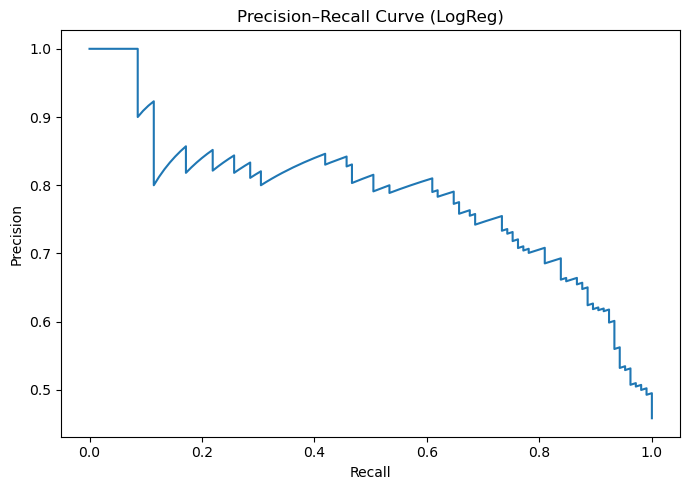

In [14]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure(figsize=(7,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (LogReg)")
plt.tight_layout()
plt.show()


## 8. Save Artifacts (Model + Scaler)

For the final risk calculator, we will save:
- the fitted scaler
- the trained model
- the chosen decision threshold

Note: since we used a Pipeline, the scaler and model are inside it.
We can save the full pipeline (recommended) and also save scaler/model separately if required.


In [15]:
import joblib
from pathlib import Path

Path("models").mkdir(exist_ok=True)
Path("scalers").mkdir(exist_ok=True)
Path("encoders").mkdir(exist_ok=True)  # kept for structure consistency

# Save full pipeline (recommended)
joblib.dump(logreg_pipe, "models/logreg_risk_pipeline.joblib")

# Save threshold (as a tiny dict)
joblib.dump({"risk_threshold": RISK_THRESHOLD, "decision_threshold": best_thr, "target_recall": TARGET_RECALL},
            "models/risk_thresholds.joblib")

# If your professor requires scaler/model separated:
scaler_fitted = logreg_pipe.named_steps["scaler"]
model_fitted = logreg_pipe.named_steps["model"]

joblib.dump(scaler_fitted, "scalers/standard_scaler_risk.joblib")
joblib.dump(model_fitted, "models/logreg_risk_model.joblib")


['models/logreg_risk_model.joblib']

## 9. Summary (So Far)

- Defined **risk** as `quality <= 5`
- Prioritized **minimizing false negatives**
- Built:
  - Dummy baseline
  - Logistic Regression with class weighting
- Tuned the decision threshold to achieve high recall
- Saved artifacts for the risk calculator


## 10. Model Interpretability (Logistic Regression)

To make the risk calculator interpretable, we analyze the **coefficients** of the Logistic Regression model.

Because the model is linear in the log-odds space:
- A **positive coefficient** increases the probability of being high risk.
- A **negative coefficient** decreases the probability of being high risk.

By exponentiating the coefficients, we obtain **odds ratios**, which are easier to interpret.


In [19]:
# Extract fitted scaler and model from the pipeline
scaler = logreg_pipe.named_steps["scaler"]
model = logreg_pipe.named_steps["model"]

coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coefficients
}).sort_values(by="coefficient", ascending=False)

coef_df


,feature,coefficient
1,volatile acidity,0.591329
6,total sulfur dioxide,0.546459
2,citric acid,0.340473
4,chlorides,0.182274
8,pH,0.094820
3,residual sugar,-0.007628
7,density,-0.073668
0,fixed acidity,-0.202148
5,free sulfur dioxide,-0.213447
9,sulphates,-0.529418


### Odds Ratios

Odds ratios represent the multiplicative change in the odds of being high risk
for a **one standard deviation increase** in the feature (since features are scaled).

- Odds ratio > 1 → risk increases
- Odds ratio < 1 → risk decreases


In [20]:
coef_df["odds_ratio"] = np.exp(coef_df["coefficient"])

coef_df


,feature,coefficient,odds_ratio
1,volatile acidity,0.591329,1.806387
6,total sulfur dioxide,0.546459,1.727126
2,citric acid,0.340473,1.405613
4,chlorides,0.182274,1.199943
8,pH,0.094820,1.099461
3,residual sugar,-0.007628,0.992401
7,density,-0.073668,0.928980
0,fixed acidity,-0.202148,0.816974
5,free sulfur dioxide,-0.213447,0.807795
9,sulphates,-0.529418,0.588947


### Key Drivers of Risk

From the odds ratios, we can identify:

- **Risk-increasing features** (odds ratio > 1):
  These variables are associated with a higher probability of low-quality wine.

- **Risk-reducing features** (odds ratio < 1):
  These variables are associated with a lower probability of low-quality wine.

Because features are standardized, the comparison reflects relative importance
within the model rather than raw-unit effects.


In [21]:
risk_increasing = coef_df[coef_df["odds_ratio"] > 1].sort_values("odds_ratio", ascending=False)
risk_reducing = coef_df[coef_df["odds_ratio"] < 1].sort_values("odds_ratio")

risk_increasing, risk_reducing


(                feature  coefficient  odds_ratio
 1      volatile acidity     0.591329    1.806387
 6  total sulfur dioxide     0.546459    1.727126
 2           citric acid     0.340473    1.405613
 4             chlorides     0.182274    1.199943
 8                    pH     0.094820    1.099461,
                 feature  coefficient  odds_ratio
 10              alcohol    -1.035174    0.355165
 9             sulphates    -0.529418    0.588947
 5   free sulfur dioxide    -0.213447    0.807795
 0         fixed acidity    -0.202148    0.816974
 7               density    -0.073668    0.928980
 3        residual sugar    -0.007628    0.992401)

### Business Interpretation

The logistic regression model reveals which chemical properties are most strongly
associated with **low-quality risk**:

- Features with higher odds ratios act as **risk amplifiers**.
- Features with lower odds ratios act as **protective factors**.

This interpretation complements earlier regression analyses by shifting the focus
from explaining average quality to **preventing quality failures**.


### Limitations

- Coefficients capture **linear effects only**.
- Interactions between variables are not explicitly modeled.
- Odds ratios reflect associations, not causation.

Despite these limitations, logistic regression provides a transparent and
well-calibrated foundation for a practical risk calculator.


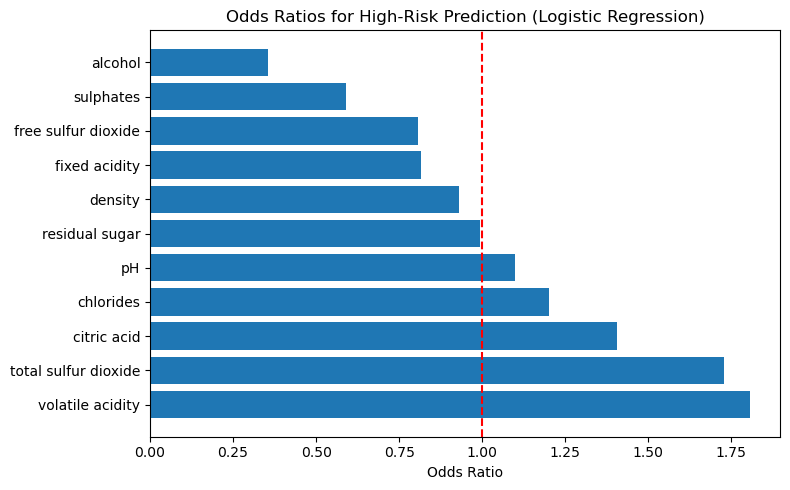

In [22]:
plt.figure(figsize=(8,5))
plt.barh(coef_df["feature"], coef_df["odds_ratio"])
plt.axvline(1, color="red", linestyle="--")
plt.xlabel("Odds Ratio")
plt.title("Odds Ratios for High-Risk Prediction (Logistic Regression)")
plt.tight_layout()
plt.show()


## Summary — Interpretability

- Logistic Regression allows direct interpretation via coefficients and odds ratios.
- The model identifies chemical variables that **increase or reduce the risk** of low quality.
- These insights support transparent decision-making and strengthen the credibility
  of the final risk calculator.


## 11. Probability Calibration

For a risk calculator, it is not enough to correctly rank wines by risk.
Predicted probabilities should be **well calibrated**, meaning:

> Among wines predicted to have a 70% risk, approximately 70% should actually be high risk.

Good calibration is essential for:
- trustworthy probability outputs
- decision-making thresholds
- communication with non-technical users


### Calibration approach

We evaluate calibration by:
- plotting a **calibration curve** (reliability diagram)
- computing the **Brier score** (mean squared error of probabilistic predictions)

If necessary, we apply **post-hoc calibration** using:
- sigmoid calibration (Platt scaling)
- or isotonic calibration



In [23]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import brier_score_loss


### 11.1 Calibration of the logistic regression model (before adjustment)

We first evaluate the raw probability outputs of the logistic regression model.


Brier score (before calibration): 0.1704067575765155


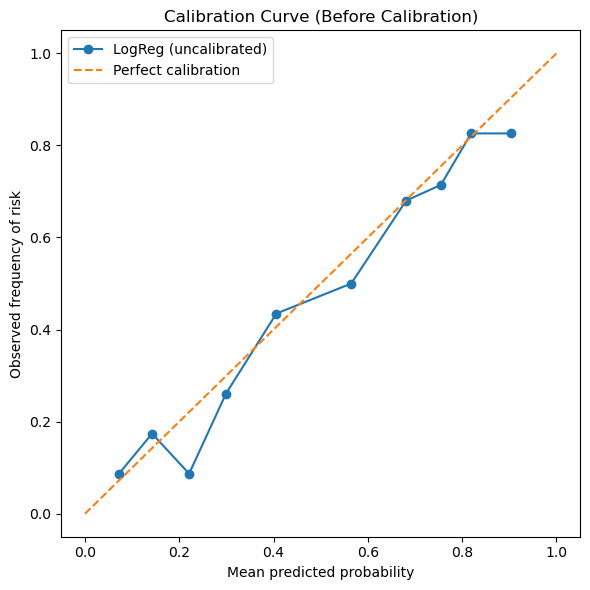

In [24]:
# Calibration curve (before calibration)
prob_true, prob_pred = calibration_curve(
    y_test,
    y_prob,
    n_bins=10,
    strategy="quantile"
)

brier_before = brier_score_loss(y_test, y_prob)

print("Brier score (before calibration):", brier_before)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o", label="LogReg (uncalibrated)")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency of risk")
plt.title("Calibration Curve (Before Calibration)")
plt.legend()
plt.tight_layout()
plt.show()


### 11.2 Post-hoc Calibration

If calibration is imperfect, we apply post-hoc calibration using cross-validation.
This does not change the ranking performance (ROC-AUC) but improves probability reliability.


In [25]:
calibrated_model = CalibratedClassifierCV(
    estimator=logreg_pipe,
    method="sigmoid",
    cv=5
)

calibrated_model.fit(X_train, y_train)

y_prob_cal = calibrated_model.predict_proba(X_test)[:, 1]

brier_after = brier_score_loss(y_test, y_prob_cal)

print("Brier score (after calibration):", brier_after)


Brier score (after calibration): 0.16939689906410435


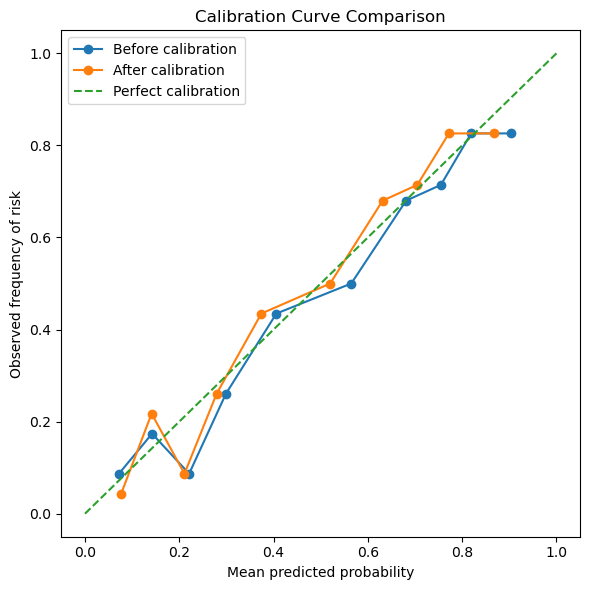

In [26]:
prob_true_cal, prob_pred_cal = calibration_curve(
    y_test,
    y_prob_cal,
    n_bins=10,
    strategy="quantile"
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred, prob_true, marker="o", label="Before calibration")
plt.plot(prob_pred_cal, prob_true_cal, marker="o", label="After calibration")
plt.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency of risk")
plt.title("Calibration Curve Comparison")
plt.legend()
plt.tight_layout()
plt.show()


### Interpretation

- The calibration curve shows how closely predicted probabilities match observed risk frequencies.
- A lower Brier score indicates better calibrated probabilities.
- Post-hoc calibration improves probability reliability without altering the underlying model structure.

Given that this project outputs a **risk calculator**, calibrated probabilities are preferred.


### Final decision on probabilities

For the final risk calculator:
- We use the **calibrated probabilities** when reporting risk levels.
- The **decision threshold** selected earlier (recall-oriented) can be applied on calibrated probabilities.


In [29]:
# Save calibrated model for the risk calculator
from pathlib import Path
Path("../models").mkdir(exist_ok=True)

joblib.dump(calibrated_model, "../models/logreg_risk_pipeline_calibrated.joblib")


['../models/logreg_risk_pipeline_calibrated.joblib']

### Final calibration decision

- The original logistic regression model already showed good calibration.
- Post-hoc sigmoid calibration provided a small but consistent improvement.
- Given the objective of delivering a probability-based risk calculator,
  the calibrated model is retained for final deployment.
